In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [56]:
# !pip install focal-loss
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, Input
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam

In [6]:
# glowny folder
# base_dir = '/content/drive/MyDrive/Magisterka/kodzik/Mushroom-dataset'
base_dir = '/Users/milenabiernacka/Desktop/studia/DS/semestr2/PD-magisterka/Mushroom_dataset/cnn'

In [7]:
# polaczenie glownego folderu i podfolderow z edible i poisonous

edible_dir = os.path.join(base_dir, 'Edible')
poisonous_dir = os.path.join(base_dir, 'Poisonous')

## Wyświetlanie kilku zdjęć

Sample Edible Mushrooms:


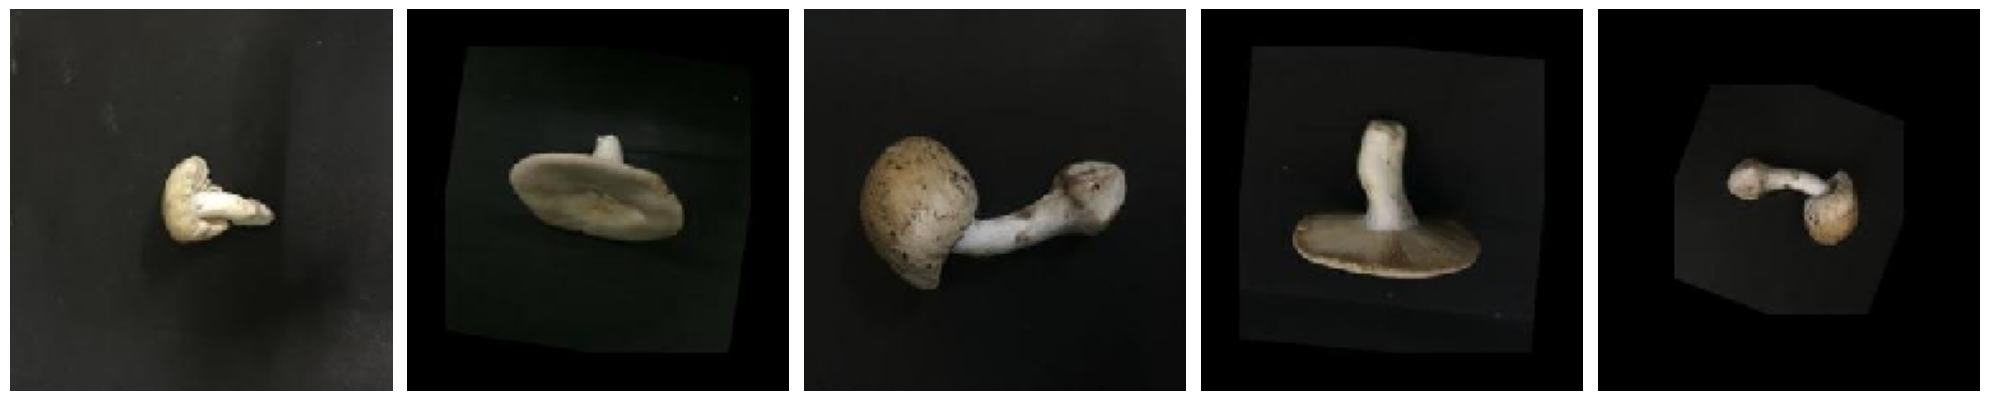

Sample Poisonous Mushrooms:


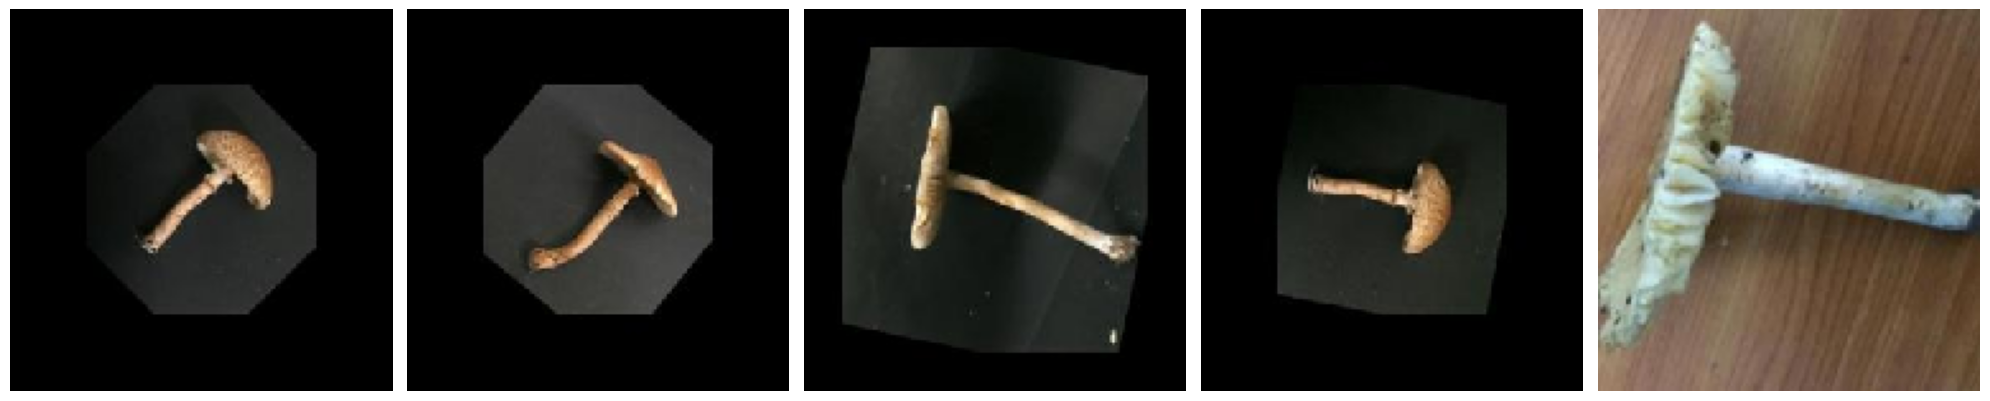

In [8]:
def display_sample_images(directory, num_images=5):
    fig, ax = plt.subplots(nrows=1, ncols=num_images, figsize=(20, 20))
    files = [os.path.join(directory, file) for file in os.listdir(directory) if file.lower().endswith(('png', 'jpg', 'jpeg'))][:num_images]
    for i, img_path in enumerate(files):
        img = image.load_img(img_path, target_size=(150, 150))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()

# Assuming `edible_dir` and `poisonous_dir` are correctly pointing to the directories
print("Sample Edible Mushrooms:")
display_sample_images(edible_dir)  # Make sure edible_dir points to the directory containing edible mushroom images
print("Sample Poisonous Mushrooms:")
display_sample_images(poisonous_dir)  # Make sure poisonous_dir points to the directory containing poisonous mushroom images


## Podział na zbiory

Raz wykonane, nie trzeba powtarzać

In [ ]:
# Categories you have
# categories = ['Edible', 'Poisonous']

In [ ]:
# # Split percentages
# train_size = 0.7
# validation_size = 0.15
# test_size = 0.15  # Explicitly define test size for clarity

# # Function to perform the split
# def split_data(category):
#     source_dir = os.path.join(base_dir, category)
#     files = os.listdir(source_dir)

#     # First split: Separating test set
#     train_val_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

#     # Adjust validation size relative to the train+validation subset
#     relative_validation_size = validation_size / (1 - test_size)

#     # Second split: Separating validation set from train+validation subset
#     train_files, validation_files = train_test_split(train_val_files, test_size=relative_validation_size, random_state=42)

#     # Function to copy files to their designated split directories
#     def copy_files(files, split_type):
#         dest_dir = os.path.join(base_dir, split_type, category)
#         for file in files:
#             shutil.copy(os.path.join(source_dir, file), os.path.join(dest_dir, file))

#     # Copy files according to the splits
#     copy_files(train_files, 'train')
#     copy_files(validation_files, 'validation')
#     copy_files(test_files, 'test')

# # Create directories for the splits
# for split in ['train', 'validation', 'test']:
#     for category in categories:
#         os.makedirs(os.path.join(base_dir, split, category), exist_ok=True)

# # Perform the split for each category
# for category in categories:
#     split_data(category)

# print("Dataset successfully split into train, validation, and test sets, original dataset preserved.")

Dataset successfully split into train, validation, and test sets, original dataset preserved.


## Przykładowa sień neuronowa

### obiekty Image Data Generator dla zestawu testowego i walidacyjnego

In [69]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Assuming base_dir is the path to the dataset directory
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=16,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=16,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

Found 1399 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 301 images belonging to 2 classes.


Sprawdzenie stosunku klas w zbiorach

In [70]:
# Assuming train_generator and test_generator are already created using flow_from_directory
train_classes = train_generator.classes
test_classes = test_generator.classes

# Count the occurrences of each class in the training set
unique, counts = np.unique(train_classes, return_counts=True)
train_class_distribution = dict(zip(train_generator.class_indices.keys(), counts))
print("Training class distribution:", train_class_distribution)

# Calculate ratios for training set
train_total = sum(counts)
train_class_ratios = {class_name: count / train_total for class_name, count in train_class_distribution.items()}
print("Training class ratios:", train_class_ratios)

# Repeat for the test set
unique, counts = np.unique(test_classes, return_counts=True)
test_class_distribution = dict(zip(test_generator.class_indices.keys(), counts))
print("Testing class distribution:", test_class_distribution)

# Calculate ratios for testing set
test_total = sum(counts)
test_class_ratios = {class_name: count / test_total for class_name, count in test_class_distribution.items()}
print("Testing class ratios:", test_class_ratios)


Training class distribution: {'Edible': 1031, 'Poisonous': 368}
Training class ratios: {'Edible': 0.7369549678341673, 'Poisonous': 0.26304503216583275}
Testing class distribution: {'Edible': 221, 'Poisonous': 80}
Testing class ratios: {'Edible': 0.7342192691029901, 'Poisonous': 0.26578073089701}


In [71]:
train_generator.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [72]:
model = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='linear')  # Use linear activation for Hinge loss
])


model.compile(optimizer=Adam(learning_rate=1e-4), loss='hinge', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)



Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 18s 193ms/step - accuracy: 0.7135 - loss: 0.6824 - val_accuracy: 0.7361 - val_loss: 0.5273
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - accuracy: 0.6875 - loss: 0.2883 - val_accuracy: 0.7500 - val_loss: 0.2211
Epoch 3/10


2024-03-09 09:04:32.383530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-09 09:04:32.417230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


87/87 ━━━━━━━━━━━━━━━━━━━━ 17s 194ms/step - accuracy: 0.7321 - loss: 0.5349 - val_accuracy: 0.7326 - val_loss: 0.4920
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - accuracy: 0.7500 - loss: 0.2616 - val_accuracy: 0.8333 - val_loss: 0.1471
Epoch 5/10


2024-03-09 09:04:49.755220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-09 09:04:49.793591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


87/87 ━━━━━━━━━━━━━━━━━━━━ 18s 203ms/step - accuracy: 0.7327 - loss: 0.4845 - val_accuracy: 0.7431 - val_loss: 0.4299
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - accuracy: 0.6875 - loss: 0.2525 - val_accuracy: 0.7500 - val_loss: 0.2281
Epoch 7/10


2024-03-09 09:05:07.966156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-09 09:05:08.003489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 210ms/step - accuracy: 0.7721 - loss: 0.4148 - val_accuracy: 0.7951 - val_loss: 0.3481
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - accuracy: 0.6875 - loss: 0.2568 - val_accuracy: 0.7500 - val_loss: 0.3056
Epoch 9/10


2024-03-09 09:05:26.795673: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-09 09:05:26.834365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


87/87 ━━━━━━━━━━━━━━━━━━━━ 20s 223ms/step - accuracy: 0.8258 - loss: 0.3425 - val_accuracy: 0.8507 - val_loss: 0.2962
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - accuracy: 0.8750 - loss: 0.1474 - val_accuracy: 0.7500 - val_loss: 0.1894


2024-03-09 09:05:46.760823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-09 09:05:46.802064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [73]:
model.evaluate(test_generator)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9357 - loss: 0.2868


[0.3252633810043335, 0.8471760749816895]

In [74]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9411 - loss: 0.2841
Test Loss: 0.31328362226486206, Test Accuracy: 0.8611111044883728


bazowy model

In [ ]:
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

In [ ]:
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow((1 - y_pred), gamma) * cross_entropy
        return K.mean(loss, axis=-1)
    return focal_loss_fixed

https://stackoverflow.com/questions/42081257/why-binary-crossentropy-and-categorical-crossentropy-give-different-performances/44498955#44498955 - rozważania nad używaniem binary/categorical loss a 'accuracy'

loss='binary_crossentropy', metrics=[binary_accuracy]

In [ ]:
from keras.metrics import categorical_accuracy, binary_accuracy

# For model using Categorical Cross Entropy
model_ce = create_model()
model_ce.compile(optimizer='adam', loss='binary_crossentropy', metrics=[binary_accuracy])

history_ce = model_ce.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/15
70/70 [==============================] - 9s 93ms/step - loss: 0.5531 - binary_accuracy: 0.7336 - val_loss: 0.4799 - val_binary_accuracy: 0.7633
Epoch 2/15
70/70 [==============================] - 7s 93ms/step - loss: 0.4120 - binary_accuracy: 0.8007 - val_loss: 0.3950 - val_binary_accuracy: 0.8167
Epoch 3/15
70/70 [==============================] - 10s 139ms/step - loss: 0.2925 - binary_accuracy: 0.8693 - val_loss: 0.4758 - val_binary_accuracy: 0.8000
Epoch 4/15
70/70 [==============================] - 9s 127ms/step - loss: 0.2151 - binary_accuracy: 0.9170 - val_loss: 0.2497 - val_binary_accuracy: 0.8833
Epoch 5/15
70/70 [==============================] - 7s 103ms/step - loss: 0.1578 - binary_accuracy: 0.9394 - val_loss: 0.2246 - val_binary_accuracy: 0.9300
Epoch 6/15
70/70 [==============================] - 9s 127ms/step - loss: 0.1127 - binary_accuracy: 0.9509 - val_loss: 0.3185 - val_binary_accuracy: 0.8900
Epoch 7/15
70/70 [==============================] - 7s 95ms/step 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
test_loss, test_accuracy = model_ce.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

15/15 [==============================] - 1s 76ms/step - loss: 0.3554 - binary_accuracy: 0.9267
Test Loss: 0.35539567470550537, Test Accuracy: 0.9266666769981384


In [ ]:
test_loss, test_accuracy = model_ce.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

In [ ]:
# # For model using Focal Loss
# model_fl = create_model()
# model_fl.compile(optimizer='adam', loss=focal_loss(gamma=5., alpha=0.5), metrics=['accuracy'])

# history_fl = model_fl.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#     epochs=15,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.samples // validation_generator.batch_size
# )

# # Save the model
# model_fl.save('model_focal_loss.h5')

Epoch 1/15
70/70 [==============================] - 9s 95ms/step - loss: 5.0090e-05 - accuracy: 0.2664 - val_loss: 0.0000e+00 - val_accuracy: 0.2600
Epoch 2/15
70/70 [==============================] - 7s 96ms/step - loss: 0.0000e+00 - accuracy: 0.2635 - val_loss: 0.0000e+00 - val_accuracy: 0.2600
Epoch 3/15
70/70 [==============================] - 7s 101ms/step - loss: 0.0000e+00 - accuracy: 0.2628 - val_loss: 0.0000e+00 - val_accuracy: 0.2633
Epoch 4/15
70/70 [==============================] - 7s 94ms/step - loss: 0.0000e+00 - accuracy: 0.2621 - val_loss: 0.0000e+00 - val_accuracy: 0.2600
Epoch 5/15
70/70 [==============================] - 6s 92ms/step - loss: 0.0000e+00 - accuracy: 0.2628 - val_loss: 0.0000e+00 - val_accuracy: 0.2633
Epoch 6/15
70/70 [==============================] - 7s 93ms/step - loss: 0.0000e+00 - accuracy: 0.2628 - val_loss: 0.0000e+00 - val_accuracy: 0.2600
Epoch 7/15
70/70 [==============================] - 7s 104ms/step - loss: 0.0000e+00 - accuracy: 0.2599 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# test_loss, test_accuracy = model_fl.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
# print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

15/15 [==============================] - 1s 74ms/step - loss: 0.0000e+00 - accuracy: 0.2567
Test Loss: 0.0, Test Accuracy: 0.2566666603088379


## Test FL z biblioteki keras
Wymaga etykiet 0-1

https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryFocalCrossentropy

In [ ]:
from focal_loss import BinaryFocalLoss

In [ ]:
# For model using Focal Loss
model_fl = create_model()
model_fl.compile(optimizer='adam', loss=BinaryFocalLoss(gamma=5), metrics=['accuracy'])

history_fl = model_fl.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# Save the model
model_fl.save('model_focal_loss.h5')

Epoch 1/30
70/70 [==============================] - 10s 106ms/step - loss: 0.0300 - accuracy: 0.7177 - val_loss: 0.0172 - val_accuracy: 0.7467
Epoch 2/30
70/70 [==============================] - 7s 97ms/step - loss: 0.0156 - accuracy: 0.7870 - val_loss: 0.0158 - val_accuracy: 0.8000
Epoch 3/30
70/70 [==============================] - 6s 90ms/step - loss: 0.0139 - accuracy: 0.7986 - val_loss: 0.0141 - val_accuracy: 0.8367
Epoch 4/30
70/70 [==============================] - 7s 103ms/step - loss: 0.0123 - accuracy: 0.8347 - val_loss: 0.0128 - val_accuracy: 0.8433
Epoch 5/30
70/70 [==============================] - 6s 92ms/step - loss: 0.0106 - accuracy: 0.8578 - val_loss: 0.0152 - val_accuracy: 0.8233
Epoch 6/30
70/70 [==============================] - 7s 99ms/step - loss: 0.0094 - accuracy: 0.8787 - val_loss: 0.0117 - val_accuracy: 0.8533
Epoch 7/30
70/70 [==============================] - 6s 89ms/step - loss: 0.0082 - accuracy: 0.8866 - val_loss: 0.0111 - val_accuracy: 0.8700
Epoch 8/30

In [ ]:
test_loss, test_accuracy = model_fl.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

15/15 [==============================] - 2s 75ms/step - loss: 0.0124 - accuracy: 0.9300
Test Loss: 0.012359237298369408, Test Accuracy: 0.9300000071525574


## Seesaw loss
Wymaga etykiet 0-1

Próba 1

In [ ]:
def seesaw_loss_with_penalty(y_true, y_pred, penalty=0.5):
    """
    A simplified conceptual version of seesaw loss for binary classification.
    This function penalizes the loss for the majority class and reduces the penalty
    for the minority class, attempting to balance the seesaw between classes.

    Args:
    - y_true: True labels.
    - y_pred: Predicted labels.
    - penalty: The penalty factor for the majority class. Lower values reduce the loss
               contribution from the majority class.

    Returns:
    - A modified binary cross-entropy loss that incorporates class balancing.
    """
    # Standard binary cross-entropy
    bce = K.binary_crossentropy(y_true, y_pred)

    # Determine weights for each sample based on its true label
    weights = K.abs(y_true - penalty)  # Reduce weight for majority class (assumed to be 1)

    # Apply seesaw penalty
    weighted_bce = weights * bce

    return K.mean(weighted_bce)

In [ ]:
# For model using Focal Loss
model_sl = create_model()
model_sl.compile(optimizer='adam', loss=lambda y_true, y_pred: seesaw_loss_with_penalty(y_true, y_pred, penalty=0.8), metrics=['accuracy'])

history_sl = model_sl.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)


Epoch 1/15
70/70 [==============================] - 8s 94ms/step - loss: 0.1837 - accuracy: 0.7357 - val_loss: 0.1440 - val_accuracy: 0.7400
Epoch 2/15
70/70 [==============================] - 7s 104ms/step - loss: 0.1300 - accuracy: 0.7632 - val_loss: 0.1104 - val_accuracy: 0.7933
Epoch 3/15
70/70 [==============================] - 6s 92ms/step - loss: 0.0956 - accuracy: 0.8325 - val_loss: 0.1181 - val_accuracy: 0.7900
Epoch 4/15
70/70 [==============================] - 7s 104ms/step - loss: 0.0755 - accuracy: 0.8838 - val_loss: 0.0794 - val_accuracy: 0.9033
Epoch 5/15
70/70 [==============================] - 8s 120ms/step - loss: 0.0601 - accuracy: 0.9191 - val_loss: 0.0827 - val_accuracy: 0.8700
Epoch 6/15
70/70 [==============================] - 6s 92ms/step - loss: 0.0416 - accuracy: 0.9394 - val_loss: 0.0742 - val_accuracy: 0.8800
Epoch 7/15
70/70 [==============================] - 7s 100ms/step - loss: 0.0397 - accuracy: 0.9451 - val_loss: 0.0675 - val_accuracy: 0.9067
Epoch 8/1

In [ ]:
test_loss, test_accuracy = model_sl.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

15/15 [==============================] - 1s 72ms/step - loss: 0.0727 - accuracy: 0.9100
Test Loss: 0.07266944646835327, Test Accuracy: 0.9100000262260437


Próba 2

In [ ]:
class SeesawLossWithLogits(tf.keras.losses.Loss):
    def __init__(self, class_counts, p=0.8):
        super().__init__()
        self.class_counts = tf.constant(class_counts, dtype=tf.float32)
        self.p = p
        self.eps = 1e-6

        conditions = self.class_counts[:, None] > self.class_counts[None, :]
        trues = (self.class_counts[None, :] / self.class_counts[:, None]) ** p
        falses = tf.ones_like(self.class_counts)
        self.s = tf.where(conditions, trues, falses)

    def call(self, y_true, y_pred):
        # Adjust logits to prevent overflow
        y_pred = y_pred - tf.reduce_max(y_pred, axis=-1, keepdims=True)

        numerator = tf.exp(y_pred)
        denominator = tf.reduce_sum((1 - y_true)[:, None, :] * self.s * tf.exp(y_pred)[:, None, :], axis=-1) + tf.exp(y_pred)

        sigma = numerator / (denominator + self.eps)
        loss = tf.reduce_sum(-y_true * tf.math.log(sigma + self.eps), axis=-1)
        return tf.reduce_mean(loss)


In [ ]:
class_counts = np.sum(train_generator.classes == 0), np.sum(train_generator.classes == 1)
print("Class counts:", class_counts)

Class counts: (1037, 368)


In [ ]:
# Example: Assuming class_counts = [num_negative_samples, num_positive_samples]
class_counts = [np.sum(train_generator.classes == 0), np.sum(train_generator.classes == 1)]  # Example class counts for an imbalanced dataset

model = create_model()  # Assuming create_model() defines your model architecture

model.compile(optimizer='adam',
              loss=SeesawLossWithLogits(class_counts=class_counts),
              metrics=['accuracy'])

# Continue with your model training as usual
history = model.fit(train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
                    )


Epoch 1/15
40/70 [================>.............] - ETA: 7:55 - loss: 0.0000e+00 - accuracy: 0.5248

KeyboardInterrupt: 

## Seesaw

In [ ]:
# import tensorflow as tf

# pylint: disable = attribute-defined-outside-init, no-name-in-module, unexpected-keyword-arg
# pylint: disable = no-value-for-parameter
from tensorflow.python.ops import state_ops as tf_state_ops


class SeeSawWeightCalculator(tf.keras.layers.Layer):
    """custom layer for calculating seesaw loss weight factors"""

    def __init__(
        self, num_classes: int = 10, p_factor: float = 0.8, q_factor: float = 2.0
    ) -> None:
        """[summary]
        Args:
            num_classes (int, optional): Total # of categories. Defaults to 10.
            p_factor (float, optional): mitigation factors tuning parameter. Defaults to 0.8.
            q_factor (float, optional): compensation factors tuning parameter. Defaults to 2.0.
        """
        super().__init__(trainable=False)
        self.num_classes = num_classes
        self.p_factor = p_factor
        self.q_factor = q_factor

    def build(self, input_shape):
        """build the layer"""
        shape = (1, self.num_classes)
        self.freq_accumulator = self.add_weight(
            shape=shape,
            name="class_freqs",
            initializer=tf.ones_initializer(),
            trainable=False,
        )
        return super().build(input_shape)

    def call(self, y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """call method on the layer
        Args:
            inputs (tf.Tensor): sample wise loss values for a given batch
        Returns:
            tf.Tensor (shape = ()): loss threshold value for importance sampling
        """
        seesaw_weights = tf.ones_like(y_true)

        if self.p_factor > 0:
            seesaw_weights *= self._get_mitigator_factor(y_true)
        if self.q_factor > 0:
            seesaw_weights *= self._get_compensation_factor(y_true, y_pred)

        return seesaw_weights

    def _get_mitigator_factor(self, labels: tf.Tensor) -> tf.Tensor:
        """Calcualtes the mitigation factors for seesaw loss
        Args:
            labels (tf.Tensor): ground truth labels for the classification task
        Returns:
            tf.Tensor: mitigation factors
        """

        self.freq_accumulator = tf_state_ops.assign(
            self.freq_accumulator,
            self.freq_accumulator + tf.reduce_sum(labels, axis=0, keepdims=True),
        )
        freq_comparator = tf.tile(self.freq_accumulator, [self.num_classes, 1])
        mask = tf.cast(
            tf.greater(tf.transpose(self.freq_accumulator), freq_comparator),
            dtype=labels.dtype,
        )
        long_tail = freq_comparator / tf.transpose(self.freq_accumulator)
        mitigator = (long_tail ** self.p_factor) * mask + (1 - mask)
        return tf.gather(mitigator, tf.argmax(labels, axis=-1))

    def _get_compensation_factor(
        self, labels: tf.Tensor, logits: tf.Tensor
    ) -> tf.Tensor:
        """Calcualtes the mitigation factors for seesaw loss
        Args:
            labels (tf.Tensor): one-hot encoded ground truth labels for the classification task
            logits (tf.Tensor): predicted logits for the classification task
        Returns:
            tf.Tensor: mitigation factors
        """
        scores = tf.math.softmax(logits, axis=-1)
        gt_label = tf.argmax(labels, axis=-1)
        indices = tf.stack(
            [tf.range(0, tf.shape(logits)[0], dtype=gt_label.dtype), gt_label], axis=1
        )
        cls_score = tf.gather_nd(scores, indices)
        compensator = scores / tf.expand_dims(cls_score, axis=-1)
        mask = tf.cast(tf.greater(compensator, 1.0), dtype=labels.dtype)
        return (compensator ** self.q_factor) * mask + (1 - mask)

    def get_config(self) -> dict:
        """Setting up the layer config
        Returns:
            dict: config key-value pairs
        """
        base_config = super().get_config()
        config = {
            "num_classes": self.num_classes,
            "freq_accumulator": self.freq_accumulator,
        }
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape: tuple) -> tuple:
        """shape of the layer output"""
        return input_shape

class SeeSawLoss(tf.keras.losses.Loss):
    """
    Custom seesaw loss based on
    "Seesaw Loss for Long-Tailed Instance Segmentation (https://arxiv.org/abs/2008.10032)"
    """

    def __init__(
        self,
        num_classes: int = 10,
        p_factor: float = 0.5,
        q_factor: float = 2.0,
        axis: int = -1,
        reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE,
        **kwargs,
    ) -> None:
        """
        Args:
            num_classes (int, optional): # of classes in the whole dataset. Defaults to 10.
            p_factor (float, optional): mitigation factors tuning parameter. Defaults to 0.8.
            q_factor (float, optional): compensation factors tuning parameter. Defaults to 2.0.
            axis (int, optional): Defaults to -1.
            reduction ([type], optional): Defaults to tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE.
        """
        super().__init__(**kwargs)
        self.num_classes = num_classes

        self.axis = axis
        self.reduction = reduction
        self.weight_calculator = SeeSawWeightCalculator(
            num_classes, p_factor=p_factor, q_factor=q_factor
        )

    def call(self, y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """
        Args:
            y_true (tf.Tensor): one-hot encoded ground truth labels
            y_pred (tf.Tensor): predicted logits
        Returns:
            tf.Tensor:
        """

        # get the mitigation factors
        weights = self.weight_calculator(y_true, y_pred)
        logits = y_pred + tf.math.log(weights) * (1 - y_true)
        return tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=logits)

In [ ]:
# Create your model architecture
def create_model(num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Use softmax for multi-class classification
    ])
    return model

# Assume num_classes is the total number of classes in your dataset
num_classes = len(train_generator.class_indices)

# Assume class_counts is a list containing the number of samples for each class
class_counts = np.bincount(train_generator.classes)
# Make sure class_counts has length equal to num_classes
assert len(class_counts) == num_classes

# Initialize Seesaw Loss
seesaw_loss = SeeSawLoss(num_classes=num_classes)

# Create and compile the model with Seesaw Loss
model = create_model(num_classes)


# Note: Use the SeeSawLoss that you've already defined earlier.
model.compile(optimizer='adam', loss=seesaw_loss, metrics=['accuracy'])

# Train the model using the training and validation generators
history = model.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
    )

Epoch 1/50
70/70 [==============================] - 9s 91ms/step - loss: 0.3583 - accuracy: 0.7365 - val_loss: 0.3651 - val_accuracy: 0.7367
Epoch 2/50
70/70 [==============================] - 7s 96ms/step - loss: 0.3653 - accuracy: 0.7365 - val_loss: 0.3651 - val_accuracy: 0.7367
Epoch 3/50
70/70 [==============================] - 7s 99ms/step - loss: 0.3633 - accuracy: 0.7379 - val_loss: 0.3651 - val_accuracy: 0.7367
Epoch 4/50
70/70 [==============================] - 6s 86ms/step - loss: 0.3633 - accuracy: 0.7379 - val_loss: 0.3651 - val_accuracy: 0.7367
Epoch 5/50
70/70 [==============================] - 7s 103ms/step - loss: 0.3613 - accuracy: 0.7394 - val_loss: 0.3604 - val_accuracy: 0.7400
Epoch 6/50
70/70 [==============================] - 6s 91ms/step - loss: 0.3633 - accuracy: 0.7379 - val_loss: 0.3604 - val_accuracy: 0.7400
Epoch 7/50
70/70 [==============================] - 6s 88ms/step - loss: 0.3644 - accuracy: 0.7371 - val_loss: 0.3651 - val_accuracy: 0.7367
Epoch 8/50
7

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

15/15 [==============================] - 1s 71ms/step - loss: 0.3558 - accuracy: 0.7433
Test Loss: 0.355815589427948, Test Accuracy: 0.7433333396911621


## Hinge loss

In [44]:
for i in range(len(train_generator.classes)):
  if train_generator.classes[i] == 0:
    train_generator.classes[i] = -1

In [35]:
len(train_generator)

88

In [38]:
train_generator.samples // train_generator.batch_size

87

In [40]:
from tensorflow.keras.losses import Hinge, SquaredHinge, KLDivergence


# For model using Categorical Cross Entropy
# model_hl = create_model()
model.compile(optimizer='adam', loss=Hinge(), metrics=['accuracy'])

history_ce = model.fit(
    train_generator,
    epochs = 15,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.7358 - loss: 1.0015 - val_accuracy: 0.7361 - val_loss: 1.0000
Epoch 2/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.5000
Epoch 3/15


2024-03-09 08:38:05.587509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/milenabiernacka/anaconda3/envs/magisterka/lib/python3.12/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-03-09 08:38:05.611666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.7124 - loss: 1.0001 - val_accuracy: 0.7292 - val_loss: 1.0000
Epoch 4/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9167 - val_loss: 0.5000
Epoch 5/15


2024-03-09 08:38:13.503164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-09 08:38:13.523485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.7371 - loss: 0.9997 - val_accuracy: 0.7396 - val_loss: 1.0000
Epoch 6/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6667 - val_loss: 0.5000
Epoch 7/15


2024-03-09 08:38:21.486410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-09 08:38:21.506275: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.7463 - loss: 0.9953 - val_accuracy: 0.7326 - val_loss: 1.0000
Epoch 8/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8333 - val_loss: 0.5000
Epoch 9/15


2024-03-09 08:38:30.155932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-09 08:38:30.177682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.7426 - loss: 1.0009 - val_accuracy: 0.7431 - val_loss: 1.0000
Epoch 10/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5833 - val_loss: 0.5000
Epoch 11/15


2024-03-09 08:38:38.654805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-09 08:38:38.677243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - accuracy: 0.7356 - loss: 1.0000 - val_accuracy: 0.7361 - val_loss: 1.0000
Epoch 12/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.5000
Epoch 13/15


2024-03-09 08:38:47.606983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-09 08:38:47.634157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.7560 - loss: 0.9997 - val_accuracy: 0.7396 - val_loss: 1.0000
Epoch 14/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6667 - val_loss: 0.5000
Epoch 15/15


2024-03-09 08:38:57.086598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-09 08:38:57.107487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.7508 - loss: 1.0000 - val_accuracy: 0.7431 - val_loss: 1.0000


In [30]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9536 - loss: 1.0000
Test Loss: 1.0, Test Accuracy: 0.7673611044883728


In [ ]:
# For model using Categorical Cross Entropy
model_hl = create_model()
model_hl.compile(optimizer='adam', loss=KLDivergence(), metrics=['accuracy'])

history_ce = model_hl.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/15
70/70 [==============================] - 10s 93ms/step - loss: 0.0024 - accuracy: 0.2650 - val_loss: -1.1927e-06 - val_accuracy: 0.2600
Epoch 2/15
70/70 [==============================] - 7s 97ms/step - loss: -1.1905e-06 - accuracy: 0.2614 - val_loss: -1.1874e-06 - val_accuracy: 0.2633
Epoch 3/15
70/70 [==============================] - 6s 87ms/step - loss: -1.1905e-06 - accuracy: 0.2614 - val_loss: -1.1874e-06 - val_accuracy: 0.2633
Epoch 4/15
70/70 [==============================] - 7s 99ms/step - loss: -1.1917e-06 - accuracy: 0.2606 - val_loss: -1.1874e-06 - val_accuracy: 0.2633
Epoch 5/15
70/70 [==============================] - 6s 87ms/step - loss: -1.1870e-06 - accuracy: 0.2635 - val_loss: -1.1874e-06 - val_accuracy: 0.2633
Epoch 6/15
70/70 [==============================] - 7s 97ms/step - loss: -1.1893e-06 - accuracy: 0.2621 - val_loss: -1.1874e-06 - val_accuracy: 0.2633
Epoch 7/15
70/70 [==============================] - 7s 93ms/step - loss: -1.1917e-06 - accuracy: 0

## ArcFace Loss

# Nowe ładowanie danych

In [ ]:
train_generator.directory

'/content/drive/MyDrive/Magisterka/kodzik/Mushroom-dataset/train'